# Fall 2025 - Assignment 2

Electronic submission on ZoneCours no later than **December 5 at 11:55 PM** of:

* This Jupyter notebook (.ipynb) as the report, after adding your answers.
* All .py files necessary to run the notebook

The report must:

* be in .ipynb format (points will be deducted for any other format).
* include the student ID number of all team members in the first cell (i.e., replace these instructions).
* answer the questions and discuss the results using tables, figures, and Markdown cells.

Grading rubric:

* **40%** Accuracy of results
* **25%** Complete and concise discussions (Markdown cells)
* **20%** Conciseness of the notebook (.ipynb with minimal code) and clarity of figures
* **15%** Code clarity (.py)

# Option Valuation with Dynamic Volatility

The objective of this assignment is to compute a synthetic, model-based counterpart to the VIX using some of the models seen in class.

In [ ]:
# The following import allow absolute imports scripts within the dorion_francois package
#import internal_script 

import datetime as dt
import os
import sys
import numpy as np
import pandas as pd
import pickle
import importlib

from scipy import stats
from scipy.optimize import minimize
import matplotlib.pyplot as plt


# Question 1

Using the data provided in `spx.csv`, estimate the parameters of Duan's (1995) nonaffine GARCH model (NGARCH) as described in the note. In particular, work under the assumption that innovations are $N(0,1)$. Note that the index levels provided in the csv file are ex-dividend, so that log returns computed from those will also be ex-dividend returns, that is:
$$
\log\left(\frac{S_{t+1}}{S_t}\right)
= r_f - y + \lambda \sqrt{h_{t+1}} - \frac{1}{2}h_{t+1} + \sqrt{h_{t+1}}\varepsilon_{t+1}
$$
In order to estimate the risk-premium parameter driving the cum-dividend equity premium $e^{\lambda \sqrt{h_{t+1}}}$, you should thus consider cum-dividend log-excess returns $\tilde{r}_{t+1} = \log\left(\frac{S_{t+1}}{S_t}\right) + y - r_f$. 

Here is how to approximate $y$: for dates prior to 1996-01-04, use the annual dividend yield values published by [Aswath Damodaran](https://pages.stern.nyu.edu/~adamodar/New_Home_Page/datafile/spearn.htm?utm_source=chatgpt.com). Then, use the yields in `spx_divyields.csv` at the shortest nonzero horizon (e.g. on 2024-12-31, the yield with expiration on 2025-01-02). Remember that both sources provide annualized yields whereas the model requires a measure at the daily frequency.

Diagnose whether $\lbrace{ \varepsilon_t }\rbrace$ are indeed $N(0,1)$ by tabulating a Jarque-Bera (JB) test and an Anderson–Darling (AD) for uniformity of $\lbrace{ u_t }\rbrace = \lbrace{ \Phi(\varepsilon_t) }\rbrace$, where $\Phi$ is the CDF of the standard normal. Also discuss a qqplot of the $\lbrace{ \varepsilon_t }\rbrace$.

_______________________________
Please note that we are using multiple points to start the optimization, in order to avoid getting stuck in a local minima. As such running question 1 can take 5+ minutes. 
____________

Estimated NGARCH(1,1) parameters (multi-start):
           lambda =  0.0414733
            omega =  1.47491e-06
            alpha =  0.0595023
             beta =  0.912369
            gamma =  0.239814
    sigma2_uncond =  5.96967e-05

Converged: True


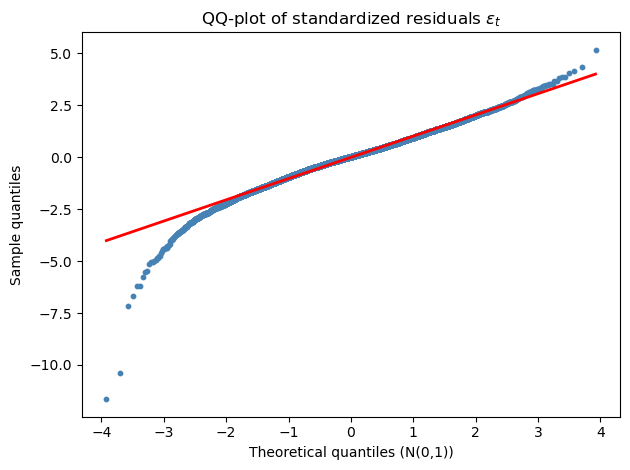

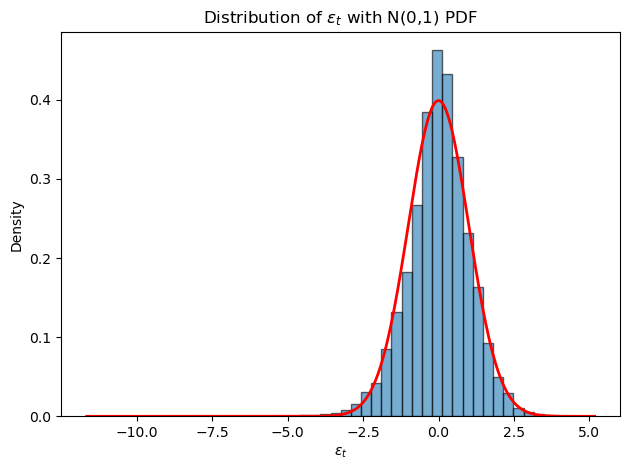

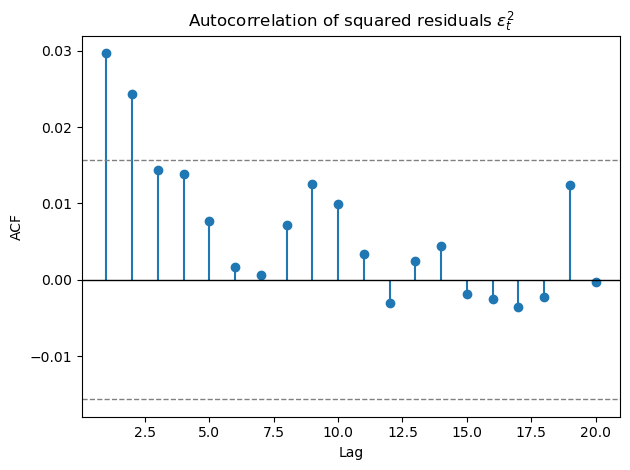

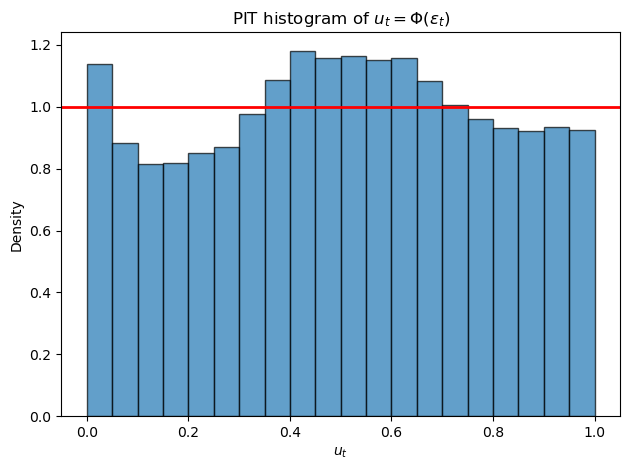


========== Residual diagnostics for epsilon t ==========

Jarque–Bera test for normality of ε_t:
  JB statistic      :  6842.9694
  p-value           :          0
  Skewness          :    -0.4827
  Pearson kurtosis  :     6.0849
  -> Reject normality of ε_t at the 5% level.

Anderson–Darling test for uniformity of u_t = Φ(ε_t):
  A^2 statistic     :    26.0556
  5% critical value :     2.4920  (large-sample)
  -> Reject uniformity of u_t at the 5% level.


In [ ]:
# ============================================================
# 1. Helper functions
# ============================================================

def annual_to_daily(y_annual_decimal, days_per_year=252):
    """
    Convert an annualized yield (decimal, e.g. 0.03 = 3%)
    to a daily yield by simple scaling.
    """
    return y_annual_decimal / days_per_year


def build_dividend_yield_series(trading_days,
                                damodaran_path='damodaran_divyields.csv',
                                spx_opt_div_path='spx_divyields.csv'):
    """
    Build a daily dividend yield series y_t aligned with 'trading_days'.
    """
    dam = pd.read_csv(damodaran_path)

    if {'Year', 'Dividend_Yield'} <= set(dam.columns):
        dam['date'] = pd.to_datetime(dam['Year'].astype(str) + '-12-31')

        div_y_pct = (
            dam['Dividend_Yield']
            .astype(str)
            .str.replace('%', '', regex=False)
            .astype(float)
        )
        dam['div_y_annual_decimal'] = div_y_pct / 100.0

        dam = dam[['date', 'div_y_annual_decimal']]
    else:
        raise ValueError(
            "Damodaran file must have columns 'Year' and 'Dividend_Yield'. "
            f"Found: {dam.columns.tolist()}"
        )

    dam.set_index('date', inplace=True)
    dam = dam.reindex(trading_days, method='ffill')
    dam['y_daily'] = annual_to_daily(dam['div_y_annual_decimal'])

    # ---------- Option-implied part (from 1996-01-04 onward) ----------
    opt = pd.read_csv(spx_opt_div_path,
                      parse_dates=['date', 'expiration'])

    opt['days_to_expiry'] = (opt['expiration'] - opt['date']).dt.days
    opt = opt[opt['days_to_expiry'] > 0]

    opt.sort_values(['date', 'days_to_expiry'], inplace=True)
    opt_short = opt.groupby('date').first().reset_index()

    opt_short = opt_short[['date', 'rate']]
    opt_short.set_index('date', inplace=True)
    opt_short = opt_short.reindex(trading_days, method='ffill')

    opt_short['div_y_annual_decimal'] = opt_short['rate'] / 100.0
    opt_short['y_daily'] = annual_to_daily(opt_short['div_y_annual_decimal'])

    cutoff = pd.Timestamp('1996-01-04')
    y = pd.Series(index=trading_days, dtype=float)

    pre = trading_days < cutoff
    post = ~pre

    y[pre] = dam.loc[trading_days[pre], 'y_daily']
    y[post] = opt_short.loc[trading_days[post], 'y_daily']

    return y


def ngarch_loglik(params, r):
    """
    Negative log-likelihood for Duan's NGARCH(1,1):
        r_t   = λ * sqrt(h_t) - 0.5 * h_t + sqrt(h_t) ε_t
        h_t   = ω + α * h_{t-1} * (ε_{t-1} - γ)^2 + β * h_{t-1}
    """
    lam, omega, alpha, beta, gamma = params

    if omega <= 0 or alpha < 0 or beta < 0:
        return 1e12

    if alpha * (1 + gamma ** 2) + beta >= 0.999:
        return 1e12

    r = np.asarray(r)
    T = len(r)
    h = np.empty(T)
    eps = np.empty(T)

    var_r = np.var(r, ddof=1)
    h[0] = var_r

    max_h = 1e4 * var_r
    max_eps2 = 1e6

    loglik = 0.0
    two_pi = 2.0 * np.pi

    for t in range(T):
        if t > 0:
            z = eps[t - 1] - gamma
            if not np.isfinite(z):
                return 1e12

            h_t = omega + alpha * h[t - 1] * (z * z) + beta * h[t - 1]

            if (h_t <= 0) or (h_t > max_h) or (not np.isfinite(h_t)):
                return 1e12

            h[t] = h_t

        mu_t = lam * np.sqrt(h[t]) - 0.5 * h[t]
        eps[t] = (r[t] - mu_t) / np.sqrt(h[t])

        if (not np.isfinite(eps[t])) or (eps[t] * eps[t] > max_eps2):
            return 1e12

        loglik += 0.5 * (np.log(two_pi) + np.log(h[t]) + eps[t] * eps[t])

    return loglik


# ---------- Multi-start helpers ----------

def generate_ngarch_starting_points(r):
    r = np.asarray(r)
    var_r = np.var(r, ddof=1)

    lambda_grid = [0.0, 0.3]
    alpha_grid  = [0.03, 0.06]
    beta_grid   = [0.92, 0.97]
    gamma_grid  = [-0.2, 0.2]

    starts = []

    for lam in lambda_grid:
        for alpha in alpha_grid:
            for beta in beta_grid:
                for gamma in gamma_grid:
                    rho = alpha * (1.0 + gamma**2) + beta
                    if rho >= 0.999:
                        continue

                    omega = var_r * (1.0 - rho)
                    if omega <= 0:
                        continue

                    starts.append(np.array([lam, omega, alpha, beta, gamma], dtype=float))

    if not starts:
        starts.append(
            np.array([0.1, var_r * 0.1, 0.05, 0.9, 0.1], dtype=float)
        )

    return starts


def estimate_ngarch_multistart(r, start_params_list=None):
    r = np.asarray(r)

    if start_params_list is None:
        start_params_list = generate_ngarch_starting_points(r)

    bounds = [
        (-5, 5),
        (1e-10, None),
        (1e-6, 1 - 1e-3),
        (1e-6, 1 - 1e-3),
        (-5, 5)
    ]

    best_res = None
    best_x = None

    for x0 in start_params_list:
        x0 = np.array(x0, dtype=float)
        for j, (low, high) in enumerate(bounds):
            if low is not None and x0[j] < low:
                x0[j] = low + 1e-8
            if high is not None and x0[j] > high:
                x0[j] = high - 1e-8

        res = minimize(
            ngarch_loglik,
            x0,
            args=(r,),
            method='L-BFGS-B',
            bounds=bounds
        )

        if not res.success:
            continue

        if (best_res is None) or (res.fun < best_res.fun):
            best_res = res
            best_x = res.x

    if best_res is None:
        raise RuntimeError("NGARCH multi-start optimization failed for all starting points.")

    lam, omega, alpha, beta, gamma = best_x

    T = len(r)
    h = np.empty(T)
    eps = np.empty(T)
    h[0] = np.var(r, ddof=1)

    for t in range(T):
        if t > 0:
            h[t] = omega + alpha * h[t - 1] * (eps[t - 1] - gamma) ** 2 + beta * h[t - 1]
        mu_t = lam * np.sqrt(h[t]) - 0.5 * h[t]
        eps[t] = (r[t] - mu_t) / np.sqrt(h[t])

    params = {
        'lambda': lam,
        'omega': omega,
        'alpha': alpha,
        'beta': beta,
        'gamma': gamma,
        'sigma2_uncond': omega / (1 - alpha * (1 + gamma ** 2) - beta)
    }

    return params, h, eps, best_res


def anderson_darling_uniform(u):
    u = np.asarray(u)
    eps = 1e-10
    u = np.clip(u, eps, 1 - eps)
    u_sorted = np.sort(u)
    n = len(u_sorted)
    i = np.arange(1, n + 1)

    s = np.sum((2 * i - 1) / n * (np.log(u_sorted) +
                                  np.log(1 - u_sorted[::-1])))
    A2 = -n - s
    return A2


def acf_1d(x, max_lag):
    """
    Simple ACF for a 1D array up to lag max_lag.
    Returns array of length max_lag with acf[lag-1] = rho_lag.
    """
    x = np.asarray(x)
    x = x[~np.isnan(x)]
    x = x - x.mean()
    T = len(x)
    denom = np.dot(x, x)

    ac = np.empty(max_lag)
    for lag in range(1, max_lag + 1):
        num = np.dot(x[:-lag], x[lag:])
        ac[lag - 1] = num / denom
    return ac


# ============================================================
# 2. Main pipeline
# ============================================================

def main():
    # ---------- Load SPX data ----------
    spx = pd.read_csv('spx.csv', parse_dates=['date'])
    spx.sort_values('date', inplace=True)
    spx.set_index('date', inplace=True)

    if not {'spindx', 'rf'} <= set(spx.columns):
        raise ValueError("spx.csv must have columns: date, spindx, rf")

    trading_days = spx.index

    # ---------- Dividend yield y_t (daily) ----------
    y_daily = build_dividend_yield_series(
        trading_days,
        damodaran_path='damodaran_divyields.csv',
        spx_opt_div_path='spx_divyields.csv'
    )

    # ---------- Risk-free rate (daily) ----------
    rf_daily = spx['rf']

    # ---------- Cum-dividend log-excess returns ----------
    log_ret = np.log(spx['spindx'] / spx['spindx'].shift(1))
    r = log_ret + y_daily.shift(1) - rf_daily.shift(1)
    r = r.dropna()

    # ---------- Estimate NGARCH with multi-start ----------
    params, h, eps, opt_res = estimate_ngarch_multistart(r)

    print("Estimated NGARCH(1,1) parameters (multi-start):")
    for k, v in params.items():
        print(f"  {k:>15s} = {v: .6g}")
    print(f"\nConverged: {opt_res.success}")

     # ---------- QQ plot of standardized residuals ----------
    fig, ax = plt.subplots()

    # Call probplot without plotting, so we can style manually
    res = stats.probplot(eps, dist="norm", plot=None)

    # res[0] = (osm, osr), res[1] = (slope, intercept[, r])
    osm, osr = res[0]
    line_params = res[1]

    # Handle SciPy versions with 2 or 3 return values
    if len(line_params) == 2:
        slope, intercept = line_params
    else:
        slope, intercept, _ = line_params

    # Steel blue points
    ax.scatter(osm, osr, color="steelblue", s=10)

    # Red reference line
    ax.plot(osm, slope * osm + intercept, color="red", linewidth=2)

    ax.set_title("QQ-plot of standardized residuals $\epsilon_t$")
    ax.set_xlabel("Theoretical quantiles (N(0,1))")
    ax.set_ylabel("Sample quantiles")

    plt.tight_layout()
    plt.show()

    # ---------- NEW PLOT 1: histogram of eps with N(0,1) pdf ----------
    fig1, ax1 = plt.subplots()
    ax1.hist(eps, bins=50, density=True, alpha=0.6, edgecolor="black")
    x_grid = np.linspace(eps.min(), eps.max(), 500)
    ax1.plot(x_grid, stats.norm.pdf(x_grid), color="orange", linewidth=2)
    ax1.set_title("Distribution of $\epsilon_t$ with N(0,1) PDF")
    ax1.set_xlabel(r"$\epsilon_t$")
    ax1.set_ylabel("Density")
    plt.tight_layout()
    plt.show()

    # ---------- NEW PLOT 2: ACF of eps^2 ----------
    eps2 = eps ** 2
    max_lag = 20
    ac_vals = acf_1d(eps2, max_lag)
    lags = np.arange(1, max_lag + 1)
    conf = 1.96 / np.sqrt(len(eps2))

    fig2, ax2 = plt.subplots()
    ax2.stem(lags, ac_vals, basefmt=" ")
    ax2.axhline(0.0, color="black", linewidth=1)
    ax2.axhline(conf, color="gray", linestyle="--", linewidth=1)
    ax2.axhline(-conf, color="gray", linestyle="--", linewidth=1)
    ax2.set_title(r"Autocorrelation of squared residuals $\epsilon_t^2$")
    ax2.set_xlabel("Lag")
    ax2.set_ylabel("ACF")
    plt.tight_layout()
    plt.show()

    # ---------- NEW PLOT 3: PIT histogram ----------
    u = stats.norm.cdf(eps)
    fig3, ax3 = plt.subplots()
    ax3.hist(u, bins=20, range=(0.0, 1.0),
             density=True, alpha=0.7, edgecolor="black")
    ax3.axhline(1.0, color="orange", linewidth=2)
    ax3.set_title(r"PIT histogram of $u_t = \Phi(\epsilon_t)$")
    ax3.set_xlabel(r"$u_t$")
    ax3.set_ylabel("Density")
    plt.tight_layout()
    plt.show()

    # ---------- Residual diagnostics (printed) ----------
    print("\n========== Residual diagnostics for epsilon t ==========\n")

    jb_stat, jb_pvalue = stats.jarque_bera(eps)
    jb_skew = stats.skew(eps, bias=False)
    jb_kurt = stats.kurtosis(eps, fisher=False, bias=False)

    print("Jarque–Bera test for normality of ε_t:")
    print(f"  JB statistic      : {jb_stat:10.4f}")
    print(f"  p-value           : {jb_pvalue:10.4g}")
    print(f"  Skewness          : {jb_skew:10.4f}")
    print(f"  Pearson kurtosis  : {jb_kurt:10.4f}")
    if jb_pvalue < 0.05:
        print("  -> Reject normality of ε_t at the 5% level.\n")
    else:
        print("  -> Do NOT reject normality of ε_t at the 5% level.\n")

    A2 = anderson_darling_uniform(u)
    print("Anderson–Darling test for uniformity of u_t = Φ(ε_t):")
    print(f"  A^2 statistic     : {A2:10.4f}")
    print(f"  5% critical value : {2.492:10.4f}  (large-sample)")
    if A2 > 2.492:
        print("  -> Reject uniformity of u_t at the 5% level.")
    else:
        print("  -> Do NOT reject uniformity of u_t at the 5% level.")

    return spx, y_daily, rf_daily, r, h, eps, params, opt_res


if __name__ == '__main__':
    spx, y_daily, rf_daily, r, h, eps, params, opt_res = main()


Estimated NGARCH(1,1) parameters (multi-start):
           lambda =  0.0414733
            omega =  1.47491e-06
            alpha =  0.0595023
             beta =  0.912369
            gamma =  0.239814
    sigma2_uncond =  5.96967e-05

Converged: True


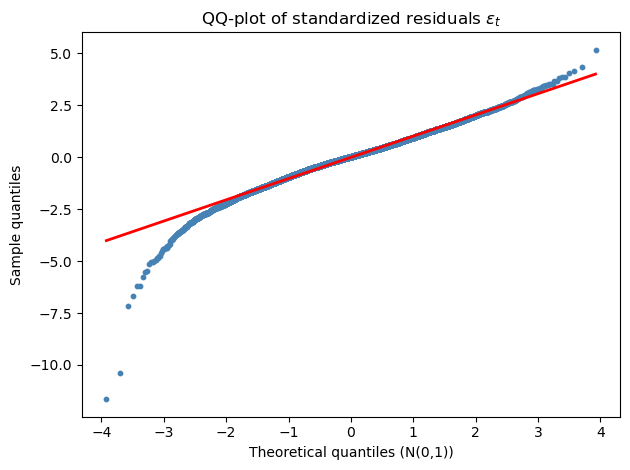

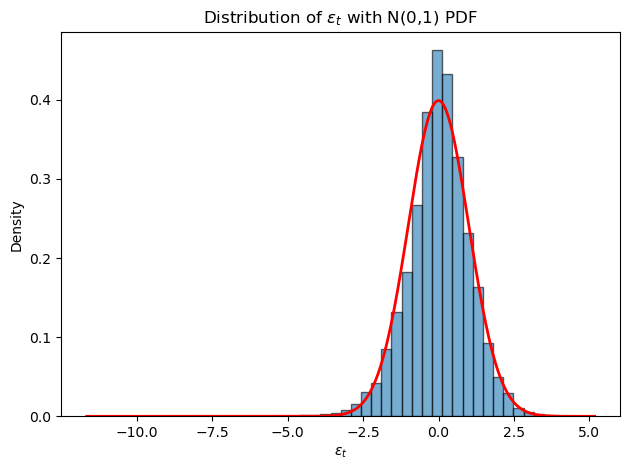

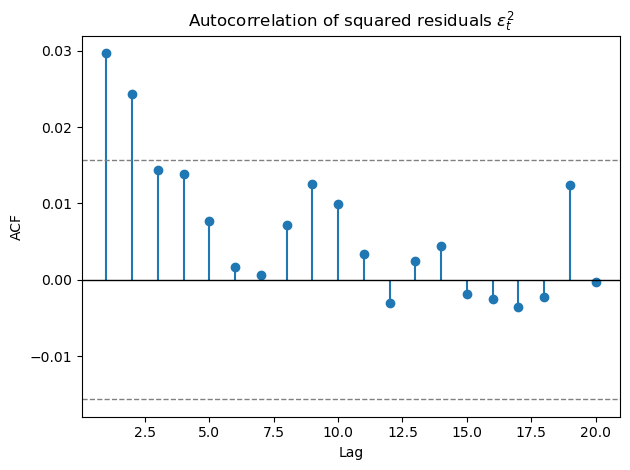

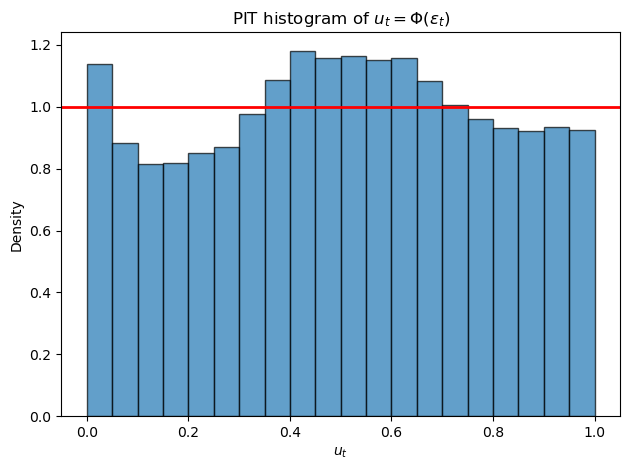


========== Residual diagnostics for epsilon t ==========

Jarque–Bera test for normality of ε_t:
  JB statistic      :  6842.9694
  p-value           :          0
  Skewness          :    -0.4827
  Pearson kurtosis  :     6.0849
  -> Reject normality of ε_t at the 5% level.

Anderson–Darling test for uniformity of u_t = Φ(ε_t):
  A^2 statistic     :    26.0556
  5% critical value :     2.4920  (large-sample)
  -> Reject uniformity of u_t at the 5% level.


In [21]:
from q1 import run_q1, estimate_ngarch_q1, plot_ngarch_diagnostics

# one-shot run with plots & stats
spx, y_daily, rf_daily, r, h, eps, params, opt_res = run_q1()


_______________
Even after fitting a garch with the assumption N(0,1) innovations, the residuals have negative skew and high kurtosis, which suggest that they are left-skewed and heavy-tailed. As for the QQ-Plot, the NGARCH model captures the bulk of the distribution well but shows fat tails, espcially, the left tail which suggest that they are many more extreme negative residuals than a normal gaussian would predict. We can likely attribute this left tail to many crashes and market downturns in the past (Dotcom bubble, 2008 crisis, pandemic, etc..) 

The formal tests are giving us the same story The Jarque–Bera statistic is very large and the p-value is essentially zero, so we strongly reject the null hypothesis that $\varepsilon_t$ is gaussian. Furthermore, The Anderson–Darling test also rejects the null hypothesis of uniformity, which means that the transformed residuals do not behave as if they were truly standard normal across the full distribution.

Looking at the additional graphics, we can see that the histogram of $\varepsilon_t$ overlaid with the N(0,1) show more mass in the center and in the extreme left tail compared to the normal, which is in line with our other results. Then the ACF of squared residuals $\varepsilon_t^2$ is small but still shows some  autocorrelation at short lags, suggesting that the NGARCH does not capture all the volatility clustering in the data. Finally, the graph for the PIT has a hump in the middle and thinner tails which shows that the gaussian assumptions of innovations is not adequate. 
_______________


# Question 2

Download the VIX data from the [Cboe website](https://cdn.cboe.com/api/global/us_indices/daily_prices/VIX_History.csv). Between Jan 1990 and Dec 2024, plot the VIX alongside $100\times$ the annualized volatilty as filtered under the Duan model. 

Describe the similarity and differences between the two series. Don't hesitate to support your analysis with statistics and statistical tests.

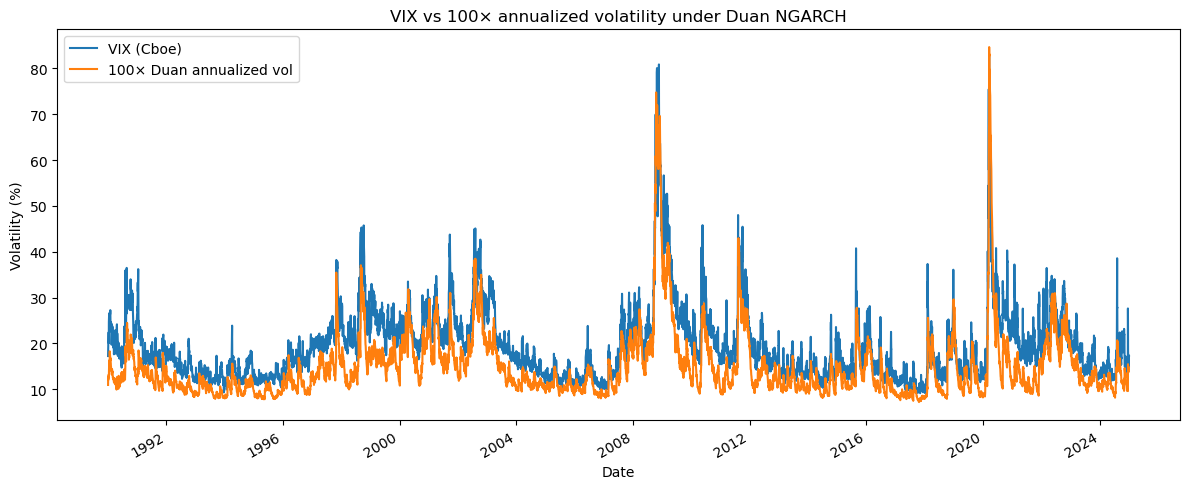

Summary statistics (Jan 1990 – Dec 2024):
               VIX  Duan_AnnVol_x100
count  8813.000000       8813.000000
mean     19.467929         14.809822
std       7.844702          7.439525
min       9.140000          7.190770
25%      13.830000         10.425471
50%      17.620000         12.686339
75%      22.820000         16.851389
max      82.690000         84.645268

Correlation matrix:
                       VIX  Duan_AnnVol_x100
VIX               1.000000          0.892769
Duan_AnnVol_x100  0.892769          1.000000


In [19]:


# ========= 1. Duan annualized volatility (×100) =========

# h is the numpy array returned by estimate_ngarch(r)
# r is the Series of filtered log-excess returns with a DatetimeIndex

h_series = pd.Series(h, index=r.index, name="h")

# daily variance -> annualized volatility (%)
duan_vol_ann = np.sqrt(252 * h_series) * 100.0
duan_vol_ann.name = "Duan_AnnVol_x100"

# ========= 2. Load VIX history from Cboe file =========

vix = pd.read_csv("VIX_History.csv")

# parse dates (format like 01/02/1990)
vix["DATE"] = pd.to_datetime(vix["DATE"], format="%m/%d/%Y")
vix.set_index("DATE", inplace=True)
vix.sort_index(inplace=True)

# use close as VIX level (already in percent, e.g. 20.05)
vix_close = vix["CLOSE"].astype(float)
vix_close.name = "VIX"

# ========= 3. Restrict to Jan 1990 – Dec 2024 and align =========

start = "1990-01-01"
end   = "2024-12-31"

vix_sub  = vix_close.loc[start:end]
duan_sub = duan_vol_ann.loc[start:end]

# inner join on dates
df = pd.concat([vix_sub, duan_sub], axis=1).dropna()

# ========= 4. Plot VIX vs 100× Duan annualized vol =========

fig, ax = plt.subplots(figsize=(12, 5))
df.plot(ax=ax)
ax.set_title("VIX vs 100× annualized volatility under Duan NGARCH")
ax.set_ylabel("Volatility (%)")
ax.set_xlabel("Date")
ax.legend(["VIX (Cboe)", "100× Duan annualized vol"])
plt.tight_layout()
plt.show()

# ========= 5. Some basic statistics / tests =========

print("Summary statistics (Jan 1990 – Dec 2024):")
print(df.describe())

print("\nCorrelation matrix:")
print(df.corr())


# Question 3

(Ideally) On each of the 8834 days in the Jan90-Dec24 sample, evaluate the option prices of 1-month, OTM puts and calls with standardized moneyness 
$$
m = \frac{\log\frac{K}{F}}{\sqrt{(252/12) h_{t+1}}}
$$
ranging from -5 to +5. To do so, you first need to apply the LRNVR to obtain the risk-neutral parametrization of the model. Prior to 1996, you can still use Damodoran's dividend yields. From 1996, use the `spx_divyields.csv` yields interpolated at 30 calendar days. Simulate $N_S$ paths over 21-business days, with $N_S = 20,000$: For each day, draw $10,000$ shocks, use the $10,000$ antithetic variates and standardize the resulting shocks (across paths, not time) to avoid simulation noise around forward prices.

Apply the VIX methodology to these options prices and plot the "model-based" VIX alongside the model's physical volatility and the actual VIX. Discuss the similarities and differences, supporting your discussion with the necessary statistics. 

Hint: start by doing the analyzing using 1 day a week (ideally, Wednesdays), to make sure you are on the right track. That will go roughly 5 times faster than working on daily data. If your computer has multiple cores, days can be analyzed in parallel.

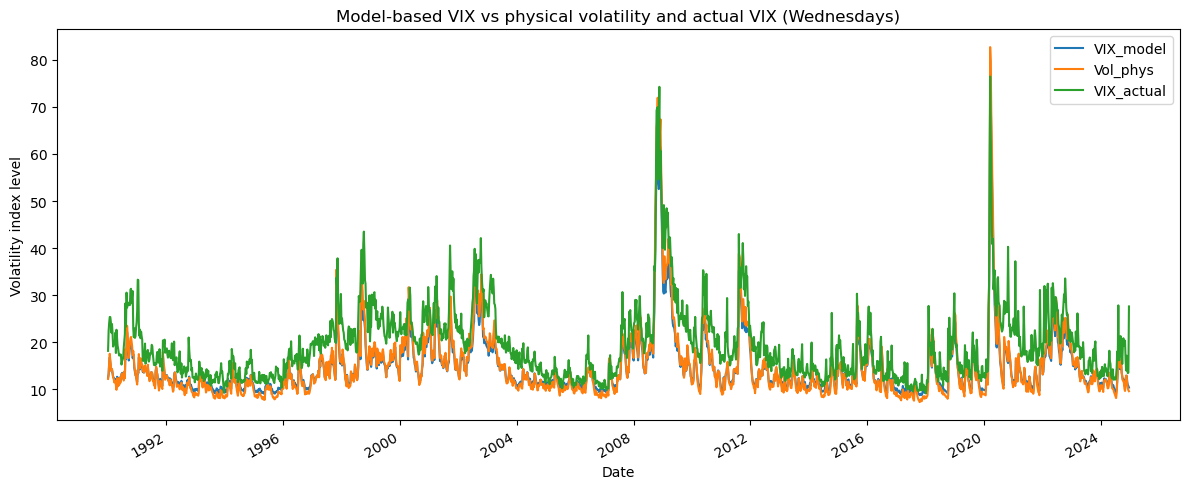

Q3 correlation matrix:
            VIX_model  Vol_phys  VIX_actual
VIX_model    1.000000  0.999386    0.893146
Vol_phys     0.999386  1.000000    0.897809
VIX_actual   0.893146  0.897809    1.000000

Q3 summary statistics:
         VIX_model     Vol_phys   VIX_actual
count  1805.000000  1805.000000  1805.000000
mean     14.727793    14.828427    19.443889
std       6.440377     7.472925     7.798583
min       8.775368     7.304338     9.150000
25%      10.987268    10.383944    13.790000
50%      12.784673    12.670446    17.770000
75%      16.358131    16.899353    22.690000
max      74.643456    82.701346    76.450000


In [5]:
# ===================== Q3: MODEL-BASED VIX =====================

# 1. Prepare series and risk-neutral parameters
h_series = pd.Series(h, index=r.index, name="h")
duan_vol_ann = np.sqrt(252.0 * h_series) * 100.0   # 100× physical NGARCH vol

def get_rn_params(params):
    """
    Risk-neutral NGARCH parameters using LRNVR:
      γ_Q = γ + λ, λ_Q = 0.
    """
    params_Q = params.copy()
    params_Q['gamma']  = params['gamma'] + params['lambda']
    params_Q['lambda'] = 0.0
    return params_Q

params_Q = get_rn_params(params)

# 2. NGARCH simulation under Q
def simulate_ngarch_paths_Q(S0, h0, rf_d, y_d, params_Q,
                            n_days=21, n_paths=20000, random_state=None):
    """
    Simulate NS paths of NGARCH under Q for n_days (business days).
    Return simulated prices at maturity S_T and last variances h_T.
    """
    rng = np.random.default_rng(random_state)
    omega = params_Q['omega']
    alpha = params_Q['alpha']
    beta  = params_Q['beta']
    gammaQ = params_Q['gamma']

    n_half = n_paths // 2
    n_paths = 2 * n_half  # ensure even
    S = np.full(n_paths, S0, dtype=float)
    h = np.full(n_paths, h0, dtype=float)

    for _ in range(n_days):
        # antithetic, standardized shocks
        z_half = rng.standard_normal(n_half)
        eps = np.concatenate([z_half, -z_half])
        eps = (eps - eps.mean()) / eps.std(ddof=1)

        # cum-dividend excess return under Q
        r_excess = -0.5 * h + np.sqrt(h) * eps
        # log return incl. rf and dividend
        log_ret = r_excess - y_d + rf_d
        S *= np.exp(log_ret)

        # update variance
        h = omega + alpha * h * (eps - gammaQ) ** 2 + beta * h

    return S, h


# 3. Option pricing on standardized moneyness grid

def build_m_grid(m_min=-5.0, m_max=5.0, n_m=41):
    return np.linspace(m_min, m_max, n_m)

def forward_and_discount(S0, rf_d, y_d, T_days=30):
    """
    Approximate 30-calendar-day forward and discount factor
    using constant daily rf_d, y_d.
    """
    R_f = rf_d * T_days             # simple 1M rate
    Q   = y_d  * T_days             # simple 1M dividend yield
    T   = T_days / 365.0
    F   = S0 * np.exp(R_f - Q)      # forward
    df  = np.exp(-R_f)              # discount factor
    return F, df, R_f, T

def price_options_from_paths(S_T, F, h0, m_grid, df):
    """
    Price 1M OTM puts/calls from simulated S_T on a standardized-m grid:
        m = log(K/F) / sqrt((252/12) h0)
    """
    S_T = np.asarray(S_T)
    sigma_bar = np.sqrt((252.0 / 12.0) * h0)
    strikes = F * np.exp(m_grid * sigma_bar)

    call_prices = []
    put_prices  = []
    for K in strikes:
        payoff_call = np.maximum(S_T - K, 0.0)
        payoff_put  = np.maximum(K - S_T, 0.0)
        call_prices.append(df * payoff_call.mean())
        put_prices.append(df * payoff_put.mean())

    return strikes, np.array(call_prices), np.array(put_prices)


# 4. CBOE VIX formula (single maturity)

def vix_from_option_curve(strikes, call_prices, put_prices, F, R_f, T):
    """
    Compute model-based VIX from a 1-month option strip using CBOE formula.
    K0 is strike just below forward F.
    """
    K = np.asarray(strikes)
    C = np.asarray(call_prices)
    P = np.asarray(put_prices)

    idx0 = np.argmin(np.abs(K - F))
    K0 = K[idx0]

    QK = np.zeros_like(K)
    for i, Ki in enumerate(K):
        if Ki < K0:
            QK[i] = P[i]
        elif Ki > K0:
            QK[i] = C[i]
        else:
            QK[i] = 0.5 * (C[i] + P[i])

    # strike spacing
    deltaK = np.zeros_like(K)
    deltaK[0] = K[1] - K[0]
    deltaK[-1] = K[-1] - K[-2]
    deltaK[1:-1] = (K[2:] - K[:-2]) / 2.0

    # CBOE variance
    sigma2 = (2.0 * np.exp(R_f) / T) * np.sum(deltaK * QK / (K**2)) \
             - (1.0 / T) * ((F / K0 - 1.0) ** 2)

    sigma2 = max(sigma2, 0.0)  # numerical safety
    VIX = 100.0 * np.sqrt(sigma2)
    return VIX, sigma2


# 5. Loop over dates (Wednesdays, in VIX sample) to build model-based VIX

# limit to dates where both NGARCH and VIX are available
vix_start = vix_close.index.min()
vix_end   = vix_close.index.max()
common_dates = r.index[(r.index >= vix_start) & (r.index <= vix_end)]

# Wednesdays only (Mon=0,...,Wed=2)
wed_dates = common_dates[common_dates.weekday == 2]

m_grid = build_m_grid()
n_paths = 20000     # you can lower this (e.g. 5000) for speed
horizon_days = 21   # business days ≈ 1 month

model_vix = pd.Series(index=wed_dates, dtype=float)

for d in wed_dates:
    S0   = spx.loc[d, 'spindx']
    h0   = h_series.loc[d]
    rf_d = rf_daily.loc[d]
    y_d  = y_daily.loc[d]

    # simulate under Q
    S_T, h_T = simulate_ngarch_paths_Q(
        S0, h0, rf_d, y_d, params_Q,
        n_days=horizon_days, n_paths=n_paths
    )

    # forward, discount, option strip, VIX
    F, df, R_f, T = forward_and_discount(S0, rf_d, y_d, T_days=30)
    strikes, C, P = price_options_from_paths(S_T, F, h0, m_grid, df)
    VIX_mod, _ = vix_from_option_curve(strikes, C, P, F, R_f, T)

    model_vix.loc[d] = VIX_mod

# 6. Compare model-based VIX, physical vol, and actual VIX

plot_df = pd.concat(
    [
        model_vix.rename("VIX_model"),
        duan_vol_ann.rename("Vol_phys"),
        vix_close.rename("VIX_actual"),
    ],
    axis=1,
    join="inner",
).dropna()

fig, ax = plt.subplots(figsize=(12, 5))
plot_df[["VIX_model", "Vol_phys", "VIX_actual"]].plot(ax=ax)
ax.set_title("Model-based VIX vs physical volatility and actual VIX (Wednesdays)")
ax.set_ylabel("Volatility index level")
ax.set_xlabel("Date")
plt.tight_layout()
plt.show()

print("Q3 correlation matrix:")
print(plot_df.corr())
print("\nQ3 summary statistics:")
print(plot_df.describe())


# Question 4

Consider the $\lbrace{ \varepsilon_t }\rbrace$ filtered under the normality assumption. We would like to leverage their empirical distribution and the fact that quasi MLE yields consistent and asymptotically normal parameter estimates. 

Filtered historical simulation is a method in which, rather than simulating innovations from a parametric distribution, innovations are sampled from the $\lbrace{ \varepsilon_t }\rbrace$ filtered during the model's estimation. These innovation, however, have been filtered under $\mathbb{P}$ and we need to simulate under $\mathbb{Q}$. 

We can, however, apply an ad-hoc risk-neutralization using the following exponential tilt. Under $\mathbb{P}$, the probability of sampling any of the $\lbrace{ \varepsilon_t }\rbrace_{t=1}^{N_T}$ should be $1/N_T$. For a scalar tilt parameter $\eta$, define
$$
q_i(\eta)
= \frac{e^{-\eta\,\varepsilon_i}}
       {\sum_{j=1}^{N_T} e^{-\eta\,\varepsilon_j}},
\qquad i=1,\dots,{N_T}.
$$
One can demonstrate that sampling $\varepsilon^Q_i = \varepsilon_i + \lambda$ with probability $q_i(\lambda)$ yields set of innovations with null expectations. Outline how this yields an ad-hoc generalization of the LRNVR where the distribution of the $\mathbb{Q}$ shocks will have a nonnormal distribution. To illustrate this point, plot a kernel density estimate of the physical distribution of the shocks along with one on a sample of $\mathbb{Q}$ shocks. Overlay to this figure, on a secondary y-axis, the likelihood ratio between the two measures and discuss.

Empirical mean under P  (ε):    -0.005855619782808998
Empirical mean under Q (ε^Q):  -0.004299537074429363


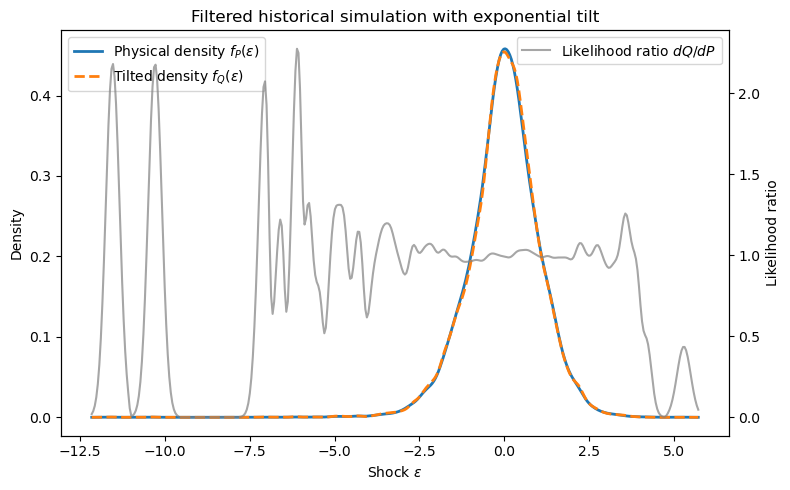

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# ---------- Inputs from earlier questions ----------
# eps    : standardized residuals ε_t from NGARCH (1D array-like)
# params : dict with key 'lambda' (risk-premium parameter)
eps_array = np.asarray(eps)
lam = params['lambda']

# ---------- 1. Exponential tilt weights q_i(η) ----------

def compute_Q_weights(eps_array, eta):
    """
    q_i(η) ∝ exp(-η ε_i)
    Under P the weights are 1/N; under Q they are q_i(η).
    """
    w = np.exp(-eta * eps_array)
    q = w / w.sum()
    return q

# ---------- 2. Sample Q-shocks via filtered historical simulation ----------

def sample_Q_shocks(eps_array, lam, n_samples=50_000, seed=123):
    """
    Sample ε^Q = ε_i + λ with prob q_i(λ).
    """
    rng = np.random.default_rng(seed)
    N = len(eps_array)
    q = compute_Q_weights(eps_array, lam)
    idx = rng.choice(N, size=n_samples, replace=True, p=q)
    eps_Q = eps_array[idx] + lam
    return eps_Q, q

eps_Q, q_weights = sample_Q_shocks(eps_array, lam)

print("Empirical mean under P  (ε):   ", eps_array.mean())
print("Empirical mean under Q (ε^Q): ", eps_Q.mean())

# ---------- 3. KDEs for P- and Q-shocks ----------

xmin = min(eps_array.min(), eps_Q.min()) - 0.5
xmax = max(eps_array.max(), eps_Q.max()) + 0.5
grid = np.linspace(xmin, xmax, 400)

kde_P = gaussian_kde(eps_array)
kde_Q = gaussian_kde(eps_Q)

f_P = kde_P(grid)
f_Q = kde_Q(grid)

eps_denom = 1e-10
likelihood_ratio = f_Q / np.maximum(f_P, eps_denom)

# ---------- 4. Plot: densities + likelihood ratio (no \mathbb) ----------

fig, ax1 = plt.subplots(figsize=(8, 5))

ax1.plot(grid, f_P, label=r"Physical density $f_P(\varepsilon)$", lw=2)
ax1.plot(grid, f_Q, label=r"Tilted density $f_Q(\varepsilon)$", lw=2, linestyle="--")
ax1.set_xlabel(r"Shock $\varepsilon$")
ax1.set_ylabel("Density")
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.plot(grid, likelihood_ratio, color="gray", alpha=0.7,
         label=r"Likelihood ratio $dQ/dP$")
ax2.set_ylabel("Likelihood ratio")
ax2.legend(loc="upper right")

plt.title("Filtered historical simulation with exponential tilt")
plt.tight_layout()
plt.show()


# Question 5

Repeat the exercise in Question 3, but using the FHS setup in Question 4 rather than $N(0,1)$ shocks. Does your VIX approximation improve? Discuss.

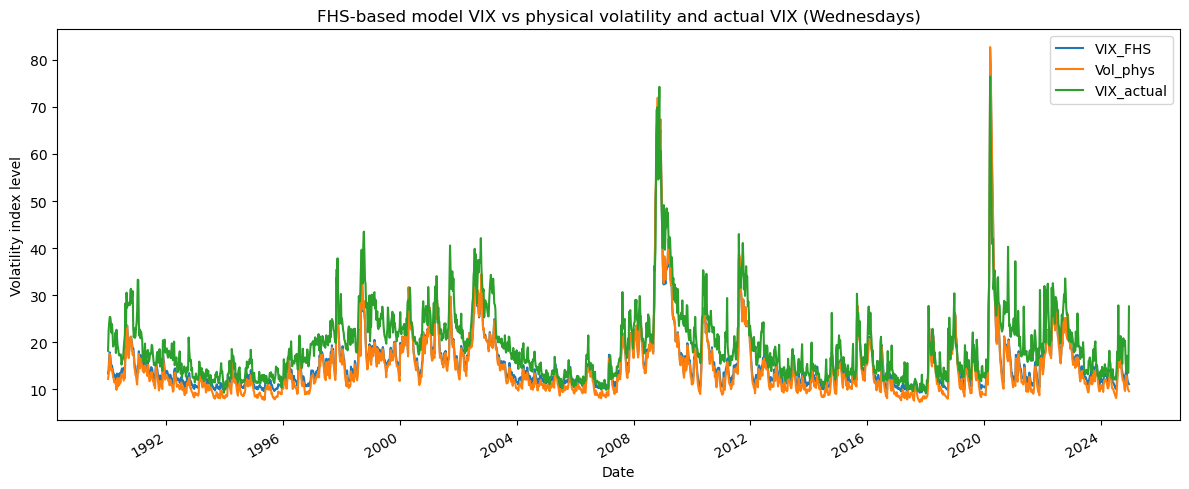

Q5 correlation matrix:
             VIX_FHS  Vol_phys  VIX_actual
VIX_FHS     1.000000  0.999442    0.893323
Vol_phys    0.999442  1.000000    0.897809
VIX_actual  0.893323  0.897809    1.000000

Q5 summary statistics:
           VIX_FHS     Vol_phys   VIX_actual
count  1805.000000  1805.000000  1805.000000
mean     15.755989    14.828427    19.443889
std       6.888903     7.472925     7.798583
min       9.311237     7.304338     9.150000
25%      11.753406    10.383944    13.790000
50%      13.693964    12.670446    17.770000
75%      17.437785    16.899353    22.690000
max      79.131557    82.701346    76.450000


In [7]:
# ====================== Q5: MODEL-BASED VIX WITH FHS SHOCKS ======================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 0. Prep: series and parameters (from earlier) ---

h_series = pd.Series(h, index=r.index, name="h")
duan_vol_ann = np.sqrt(252.0 * h_series) * 100.0   # 100× physical NGARCH vol

eps_array = np.asarray(eps)          # standardized residuals ε_t under P
lam = params['lambda']               # risk-premium parameter λ


# --- 1. Exponential-tilt weights and FHS sampling (from Q4) ---

def compute_Q_weights(eps_array, eta):
    """
    Exponential tilt weights:
        q_i(η) ∝ exp(-η ε_i)
    Normalized so that sum_i q_i(η) = 1.
    """
    w = np.exp(-eta * eps_array)
    q = w / w.sum()
    return q

# Precompute weights once
q_weights = compute_Q_weights(eps_array, lam)


def draw_eps_Q(eps_array, q_weights, lam, n_paths, rng):
    """
    Draw n_paths shocks under Q using FHS:
        ε^Q = ε_i + λ with prob q_i(λ).
    """
    N = len(eps_array)
    idx = rng.choice(N, size=n_paths, replace=True, p=q_weights)
    eps_Q = eps_array[idx] + lam
    return eps_Q


# --- 2. Risk-neutral NGARCH parameters (same LRNVR mapping as in Q3) ---

def get_rn_params(params):
    """
    LRNVR mapping:
        γ_Q = γ + λ,  λ_Q = 0.
    We keep the same volatility dynamics as in Q3,
    but shocks are now non-Gaussian (FHS).
    """
    params_Q = params.copy()
    params_Q['gamma']  = params['gamma'] + params['lambda']
    params_Q['lambda'] = 0.0
    return params_Q

params_Q = get_rn_params(params)


# --- 3. NGARCH path simulation under Q with FHS shocks ---

def simulate_ngarch_paths_Q_FHS(S0, h0, rf_d, y_d,
                                params_Q, eps_array, q_weights, lam,
                                n_days=21, n_paths=20000, random_state=None):
    """
    Simulate NS paths under Q for n_days using FHS shocks.
    At each step:
        - draw ε^Q from tilted empirical distribution (FHS)
        - update returns and variance using NGARCH recursion under Q.
    """
    rng = np.random.default_rng(random_state)

    omega = params_Q['omega']
    alpha = params_Q['alpha']
    beta  = params_Q['beta']
    gammaQ = params_Q['gamma']

    S = np.full(n_paths, S0, dtype=float)
    h = np.full(n_paths, h0, dtype=float)

    for _ in range(n_days):
        eps_Q = draw_eps_Q(eps_array, q_weights, lam, n_paths, rng)

        # 1-step cum-dividend excess return under Q (λ_Q = 0)
        r_excess = -0.5 * h + np.sqrt(h) * eps_Q

        # log equity return including rf and dividend
        log_ret = r_excess - y_d + rf_d
        S *= np.exp(log_ret)

        # NGARCH variance recursion under Q
        h = omega + alpha * h * (eps_Q - gammaQ) ** 2 + beta * h

    return S, h


# --- 4. Build FHS-based model VIX on Wednesdays (like in Q3) ---

# restrict to dates where both NGARCH and VIX exist
vix_start = vix_close.index.min()
vix_end   = vix_close.index.max()
common_dates = r.index[(r.index >= vix_start) & (r.index <= vix_end)]

# Wednesdays only (Mon=0,...,Wed=2)
wed_dates = common_dates[common_dates.weekday == 2]

m_grid = build_m_grid()
n_paths = 20000        # use 5000 if this is too slow
horizon_days = 21      # business days ≈ 1 month

vix_model_fhs = pd.Series(index=wed_dates, dtype=float)

for d in wed_dates:
    S0   = spx.loc[d, 'spindx']
    h0   = h_series.loc[d]
    rf_d = rf_daily.loc[d]
    y_d  = y_daily.loc[d]

    # Monte Carlo under Q with FHS shocks
    S_T, h_T = simulate_ngarch_paths_Q_FHS(
        S0, h0, rf_d, y_d,
        params_Q, eps_array, q_weights, lam,
        n_days=horizon_days, n_paths=n_paths
    )

    # 1-month forward, discount, option prices on m-grid
    F, df, R_f, T = forward_and_discount(S0, rf_d, y_d, T_days=30)
    strikes, C, P = price_options_from_paths(S_T, F, h0, m_grid, df)

    # VIX from model option curve
    VIX_fhs, _ = vix_from_option_curve(strikes, C, P, F, R_f, T)
    vix_model_fhs.loc[d] = VIX_fhs


# --- 5. Compare FHS VIX with Gaussian-based VIX, physical vol and actual VIX ---

# If you still have the Q3 Gaussian model VIX series, call it `vix_model_gauss`.
# If not, you can skip that column.

# example assuming you have `model_vix` from Q3:
#   model_vix.rename("VIX_gauss")

cols = [
    vix_model_fhs.rename("VIX_FHS"),
    duan_vol_ann.rename("Vol_phys"),
    vix_close.rename("VIX_actual"),
]

plot_df_q5 = pd.concat(cols, axis=1, join="inner").dropna()

fig, ax = plt.subplots(figsize=(12, 5))
plot_df_q5.plot(ax=ax)
ax.set_title("FHS-based model VIX vs physical volatility and actual VIX (Wednesdays)")
ax.set_ylabel("Volatility index level")
ax.set_xlabel("Date")
plt.tight_layout()
plt.show()

print("Q5 correlation matrix:")
print(plot_df_q5.corr())
print("\nQ5 summary statistics:")
print(plot_df_q5.describe())


# Bonus question

Instead of an ad-hoc non-normal NGARCH model, repeat the above analysis with the Bates (2000) model.

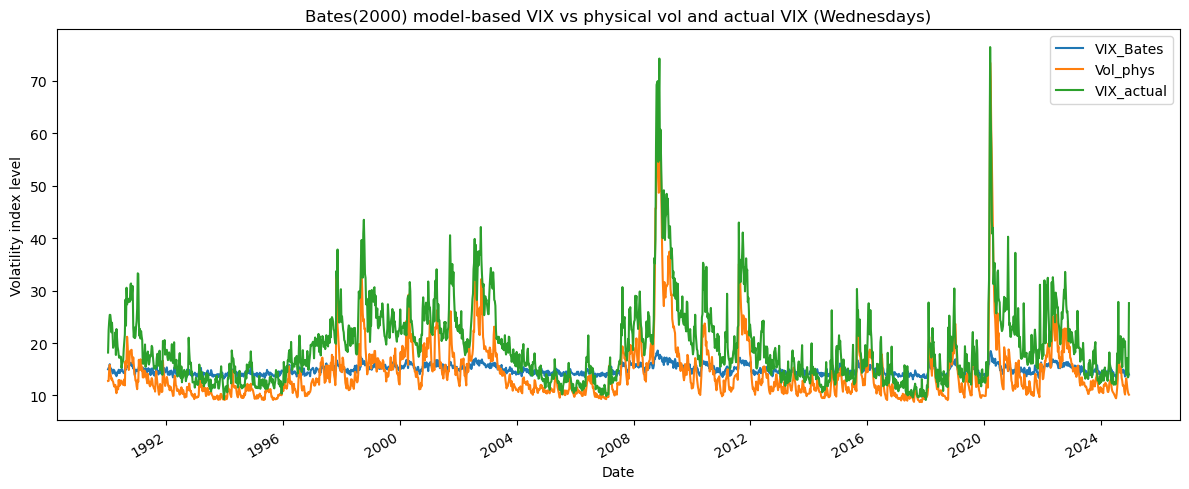

Correlation matrix (Bates vs actual VIX etc.):
            VIX_Bates  Vol_phys  VIX_actual
VIX_Bates    1.000000  0.820940    0.801995
Vol_phys     0.820940  1.000000    0.881932
VIX_actual   0.801995  0.881932    1.000000 

Summary statistics:
         VIX_Bates     Vol_phys   VIX_actual
count  1805.000000  1805.000000  1805.000000
mean     14.884140    14.329117    19.443889
std       0.854380     6.100802     7.798583
min      13.083322     8.740752     9.150000
25%      14.222945    10.857657    13.790000
50%      14.761788    12.540184    17.770000
75%      15.452607    15.825167    22.690000
max      18.570824    73.498662    76.450000


In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==========================
# 0. “Physical” vol from NGARCH (for comparison only)
# ==========================

h_series = pd.Series(h, index=r.index, name="h")
duan_vol_ann = np.sqrt(252.0 * h_series) * 100.0   # 100× daily vol → annual %


# ==========================
# 1. Helpers (same VIX machinery as Q3)
# ==========================

def build_m_grid(m_min=-5.0, m_max=5.0, n_m=41):
    """Standardized moneyness grid m ∈ [m_min, m_max]."""
    return np.linspace(m_min, m_max, n_m)


def forward_and_discount(S0, rf_d, y_d, T_days=30):
    """
    Approximate 30-calendar-day forward and discount factor
    from *daily* rf_d and dividend yield y_d (both in decimal).
    """
    R_f = rf_d * T_days           # simple 1M rate (annual ≈ rf_d*252)
    Q   = y_d  * T_days           # simple 1M dividend yield
    T   = T_days / 365.0
    F   = S0 * np.exp(R_f - Q)
    df  = np.exp(-R_f)
    return F, df, R_f, T


def vix_from_option_curve(strikes, call_prices, put_prices, F, R_f, T):
    """
    CBOE VIX formula for a single ~30-day maturity.
    """
    K = np.asarray(strikes)
    C = np.asarray(call_prices)
    P = np.asarray(put_prices)

    # Strike just below forward
    idx0 = np.argmin(np.abs(K - F))
    K0 = K[idx0]

    # OTM option “Q(K)”
    QK = np.zeros_like(K)
    for i, Ki in enumerate(K):
        if Ki < K0:
            QK[i] = P[i]             # OTM put
        elif Ki > K0:
            QK[i] = C[i]             # OTM call
        else:
            QK[i] = 0.5 * (C[i] + P[i])

    # ΔK
    deltaK = np.zeros_like(K)
    deltaK[0]  = K[1] - K[0]
    deltaK[-1] = K[-1] - K[-2]
    deltaK[1:-1] = (K[2:] - K[:-2]) / 2.0

    # Forward variance
    sigma2 = (2.0 * np.exp(R_f) / T) * np.sum(deltaK * QK / (K ** 2)) \
             - (1.0 / T) * ((F / K0 - 1.0) ** 2)

    sigma2 = max(sigma2, 0.0)  # numerical safety
    VIX = 100.0 * np.sqrt(sigma2)
    return VIX, sigma2


# ==========================
# 2. Bates(2000) dynamics under Q with fixes
# ==========================

# ► Put your (risk-neutral) Bates parameters here
batesQ_params = {
    "kappa_v":  2.0,    # mean reversion speed of variance
    "theta_v":  0.04,   # long-run variance (e.g. 20%^2)
    "sigma_v":  0.5,    # vol-of-vol
    "rho":     -0.7,    # corr(dW1, dW2)
    "lambdaJ":  0.5,    # jump intensity PER YEAR
    "muJ":     -0.1,    # mean log jump size
    "sigmaJ":   0.2     # std of log jump size
}
# You can tweak / calibrate these later.


def simulate_bates_paths_Q(S0, v0, rf_ann, y_ann, params,
                           n_days=21, n_paths=20000, random_state=None):
    """
    Simulate Bates (Heston + jumps) under Q for n_days *business* days.

    Inputs
    ------
    S0      : initial spot
    v0      : initial variance (per day; we reuse NGARCH h_t)
    rf_ann  : ANNUAL risk-free rate (decimal)
    y_ann   : ANNUAL dividend yield (decimal)
    params  : dict of Bates Q-parameters (kappa_v, theta_v, sigma_v, rho,
                                       lambdaJ, muJ, sigmaJ)
    Returns
    -------
    S_T (n_paths,), v_T (n_paths,)
    """
    rng = np.random.default_rng(random_state)

    kappa_v = params["kappa_v"]
    theta_v = params["theta_v"]
    sigma_v = params["sigma_v"]
    rho     = params["rho"]
    lambdaJ = params["lambdaJ"]   # intensity per YEAR
    muJ     = params["muJ"]
    sigmaJ  = params["sigmaJ"]

    # Jump compensator
    kappaJ     = np.exp(muJ + 0.5 * sigmaJ**2) - 1.0
    dt         = 1.0 / 252.0      # business day in years
    lambdaJ_dt = lambdaJ * dt     # Poisson parameter per step

    S = np.full(n_paths, S0, dtype=float)
    v = np.full(n_paths, v0, dtype=float)

    for _ in range(n_days):
        # Correlated Brownian increments
        z1 = rng.standard_normal(n_paths)
        z2 = rng.standard_normal(n_paths)
        dW1 = np.sqrt(dt) * z1
        dW2 = np.sqrt(dt) * (rho * z1 + np.sqrt(1 - rho**2) * z2)

        # Variance process (Heston; full truncation)
        v = np.maximum(v, 0.0)
        v_prev = v.copy()

        v = v_prev + kappa_v * (theta_v - v_prev) * dt \
                 + sigma_v * np.sqrt(np.maximum(v_prev, 0.0)) * dW2
        v = np.maximum(v, 0.0)

        # Jumps: Poisson arrivals, lognormal sizes
        nJumps = rng.poisson(lambdaJ_dt, size=n_paths)
        J = np.exp(muJ + sigmaJ * rng.standard_normal(n_paths))
        jump_factor = np.where(nJumps > 0, J, 1.0)

        # Risk-neutral drift: (r - q - λJ κJ − 0.5 v) dt
        mu_q = rf_ann - y_ann - lambdaJ * kappaJ
        dlogS = (mu_q - 0.5 * v_prev) * dt + np.sqrt(np.maximum(v_prev, 0.0)) * dW1

        S *= np.exp(dlogS) * jump_factor

    return S, v


# ==========================
# 3. Bates model-based VIX on Wednesdays
# ==========================

# 3.1 choose dates where we have both NGARCH and VIX
vix_start = vix_close.index.min()
vix_end   = vix_close.index.max()
common_dates = r.index[(r.index >= vix_start) & (r.index <= vix_end)]

# Wednesdays only (Mon=0 ... Wed=2)
wed_dates = common_dates[common_dates.weekday == 2]

m_grid       = build_m_grid()
n_paths      = 20000     # reduce if too slow
horizon_days = 21        # 21 business days ≈ 1 month

vix_model_bates = pd.Series(index=wed_dates, dtype=float)

for d in wed_dates:
    S0      = spx.loc[d, 'spindx']
    v0      = h_series.loc[d]            # treat NGARCH h_t as current variance
    rf_d    = rf_daily.loc[d]           # daily rf
    y_d     = y_daily.loc[d]            # daily dividend yield

    # convert to annual rates for the SDE drift
    rf_ann = rf_d * 252.0
    y_ann  = y_d  * 252.0

    # simulate Bates under Q
    S_T, v_T = simulate_bates_paths_Q(
        S0, v0, rf_ann, y_ann,
        batesQ_params,
        n_days=horizon_days,
        n_paths=n_paths
    )

    # Forward, discount, etc. for 30 calendar days
    F, df, R_f, T = forward_and_discount(S0, rf_d, y_d, T_days=30)

    # strikes from standardized m using *starting* variance v0
    sigma_bar = np.sqrt((252.0 / 12.0) * v0)   # √((252/12) v0)
    strikes = F * np.exp(m_grid * sigma_bar)

    # price options from terminal prices
    call_prices = []
    put_prices  = []
    for K in strikes:
        payoff_call = np.maximum(S_T - K, 0.0)
        payoff_put  = np.maximum(K - S_T, 0.0)
        call_prices.append(df * payoff_call.mean())
        put_prices.append(df * payoff_put.mean())
    call_prices = np.array(call_prices)
    put_prices  = np.array(put_prices)

    # model-based VIX from Bates option strip
    VIX_bates, _ = vix_from_option_curve(strikes, call_prices, put_prices, F, R_f, T)
    vix_model_bates.loc[d] = VIX_bates


# ==========================
# 4. Plot & statistics
# ==========================

bates_df = pd.concat(
    [
        vix_model_bates.rename("VIX_Bates"),
        duan_vol_ann.rename("Vol_phys"),
        vix_close.rename("VIX_actual"),
    ],
    axis=1,
    join="inner",
).dropna()

fig, ax = plt.subplots(figsize=(12, 5))
bates_df[["VIX_Bates", "Vol_phys", "VIX_actual"]].plot(ax=ax)
ax.set_title("Bates(2000) model-based VIX vs physical vol and actual VIX (Wednesdays)")
ax.set_ylabel("Volatility index level")
ax.set_xlabel("Date")
plt.tight_layout()
plt.show()

print("Correlation matrix (Bates vs actual VIX etc.):")
print(bates_df.corr(), "\n")

print("Summary statistics:")
print(bates_df.describe())

In [50]:
rmse_bates = np.sqrt(((bates_df["VIX_Bates"] - bates_df["VIX_actual"])**2).mean())
print(f"\nRMSE between Bates model VIX and actual VIX: {rmse_bates:.4f}")

rmse_fhs = np.sqrt(((plot_df_q5["VIX_FHS"] - plot_df_q5["VIX_actual"])**2).mean())
print(f"RMSE between FHS model VIX and actual VIX: {rmse_fhs:.4f}")

rmse_gauss = np.sqrt(((plot_df["VIX_model"] - plot_df["VIX_actual"])**2).mean())
print(f"RMSE between Gaussian model VIX and actual VIX: {rmse_gauss:.4f}")


RMSE between Bates model VIX and actual VIX: 8.4631
RMSE between FHS model VIX and actual VIX: 4.0119
RMSE between Gaussian model VIX and actual VIX: 7.0597


In [51]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# ---------- Common prep ----------
h_series = pd.Series(h, index=r.index, name="h")
duan_vol_ann = np.sqrt(252.0 * h_series) * 100.0   # physical vol proxy


# ---------- Bates(Q) parameters (initial guess) ----------
batesQ_params = {
    "kappa_v":  2.0,    # speed of mean reversion
    "theta_v":  0.04,   # long-run variance
    "sigma_v":  0.5,    # vol-of-vol
    "rho":     -0.7,    # corr between price and variance shocks
    "lambdaJ":  0.5,    # jump intensity per YEAR
    "muJ":     -0.1,    # mean log jump size
    "sigmaJ":   0.2     # std of log jump size
}


def simulate_bates_paths_Q(S0, v0, rf_ann, y_ann, params,
                           n_days=21, n_paths=20000, random_state=None):
    """
    Simulate Bates (Heston + jumps) under Q for n_days business days.
    v0 is *daily* variance (we reuse NGARCH h_t).
    rf_ann, y_ann are ANNUAL rates (decimal).
    """
    rng = np.random.default_rng(random_state)

    kappa_v = params["kappa_v"]
    theta_v = params["theta_v"]
    sigma_v = params["sigma_v"]
    rho     = params["rho"]
    lambdaJ = params["lambdaJ"]   # per year
    muJ     = params["muJ"]
    sigmaJ  = params["sigmaJ"]

    kappaJ     = np.exp(muJ + 0.5 * sigmaJ**2) - 1.0
    dt         = 1.0 / 252.0
    lambdaJ_dt = lambdaJ * dt

    S = np.full(n_paths, S0, dtype=float)
    v = np.full(n_paths, v0, dtype=float)

    for _ in range(n_days):
        # correlated Brownian increments
        z1 = rng.standard_normal(n_paths)
        z2 = rng.standard_normal(n_paths)
        dW1 = np.sqrt(dt) * z1
        dW2 = np.sqrt(dt) * (rho * z1 + np.sqrt(1 - rho**2) * z2)

        # variance dynamics (full truncation Heston)
        v = np.maximum(v, 0.0)
        v_prev = v.copy()
        v = v_prev + kappa_v * (theta_v - v_prev) * dt \
                 + sigma_v * np.sqrt(np.maximum(v_prev, 0.0)) * dW2
        v = np.maximum(v, 0.0)

        # jumps
        nJumps = rng.poisson(lambdaJ_dt, size=n_paths)
        J = np.exp(muJ + sigmaJ * rng.standard_normal(n_paths))
        jump_factor = np.where(nJumps > 0, J, 1.0)

        # risk-neutral drift for log S
        mu_q = rf_ann - y_ann - lambdaJ * kappaJ
        dlogS = (mu_q - 0.5 * v_prev) * dt + np.sqrt(np.maximum(v_prev, 0.0)) * dW1

        S *= np.exp(dlogS) * jump_factor

    return S, v


def compute_bates_vix_series(params, dates, n_paths=10000):
    """
    Compute Bates model-based VIX on given dates (typically Wednesdays).
    Uses NGARCH h_t as current variance v0 at each date.
    """
    m_grid       = build_m_grid()
    horizon_days = 21

    vix_bates = pd.Series(index=dates, dtype=float)

    for d in dates:
        S0   = spx.loc[d, 'spindx']
        v0   = h_series.loc[d]
        rf_d = rf_daily.loc[d]      # daily
        y_d  = y_daily.loc[d]

        rf_ann = rf_d * 252.0
        y_ann  = y_d  * 252.0

        # simulate under Bates Q
        S_T, v_T = simulate_bates_paths_Q(
            S0, v0, rf_ann, y_ann, params,
            n_days=horizon_days, n_paths=n_paths
        )

        # forward & discount for 30 calendar days
        F, df, R_f, T = forward_and_discount(S0, rf_d, y_d, T_days=30)

        # standardized-m strikes using starting variance v0
        sigma_bar = np.sqrt((252.0 / 12.0) * v0)
        strikes = F * np.exp(m_grid * sigma_bar)

        call_prices, put_prices = [], []
        for K in strikes:
            payoff_call = np.maximum(S_T - K, 0.0)
            payoff_put  = np.maximum(K - S_T, 0.0)
            call_prices.append(df * payoff_call.mean())
            put_prices.append(df * payoff_put.mean())

        call_prices = np.array(call_prices)
        put_prices  = np.array(put_prices)

        VIX_b, _ = vix_from_option_curve(strikes, call_prices, put_prices, F, R_f, T)
        vix_bates.loc[d] = VIX_b

    return vix_bates


In [52]:
# ---------- Calibration set: sub-sampled Wednesdays ----------
vix_start = vix_close.index.min()
vix_end   = vix_close.index.max()
common_dates = r.index[(r.index >= vix_start) & (r.index <= vix_end)]
wed_dates = common_dates[common_dates.weekday == 2]

# e.g. every 3rd Wednesday to speed things up
calib_dates = wed_dates[::3]


def bates_rmse_theta_lambda(x):
    """
    x[0] = theta_v, x[1] = lambdaJ
    returns RMSE between Bates VIX and actual VIX on calib_dates.
    """
    theta_v, lambdaJ = x
    params_local = batesQ_params.copy()
    params_local["theta_v"]  = theta_v
    params_local["lambdaJ"]  = lambdaJ

    vix_bates_calib = compute_bates_vix_series(params_local, calib_dates, n_paths=5000)
    df_calib = pd.concat(
        [vix_bates_calib.rename("VIX_Bates"),
         vix_close.loc[calib_dates].rename("VIX_actual")],
        axis=1
    ).dropna()

    rmse = np.sqrt(((df_calib["VIX_Bates"] - df_calib["VIX_actual"])**2).mean())
    return rmse


# initial guess and bounds
x0 = np.array([batesQ_params["theta_v"], batesQ_params["lambdaJ"]])
bounds = [(0.01, 0.15),   # theta_v between 10% and 39% annual vol^2
          (0.01, 1.50)]   # lambdaJ between 0.01 and 1.5 per year

res = minimize(bates_rmse_theta_lambda, x0, bounds=bounds, method="L-BFGS-B")
print("Calibration result (theta_v, lambdaJ):", res.x, "RMSE:", res.fun)

# update global Bates params with calibrated values
batesQ_params["theta_v"], batesQ_params["lambdaJ"] = res.x


Calibration result (theta_v, lambdaJ): [0.03999994 0.49999903] RMSE: 8.37652760683698


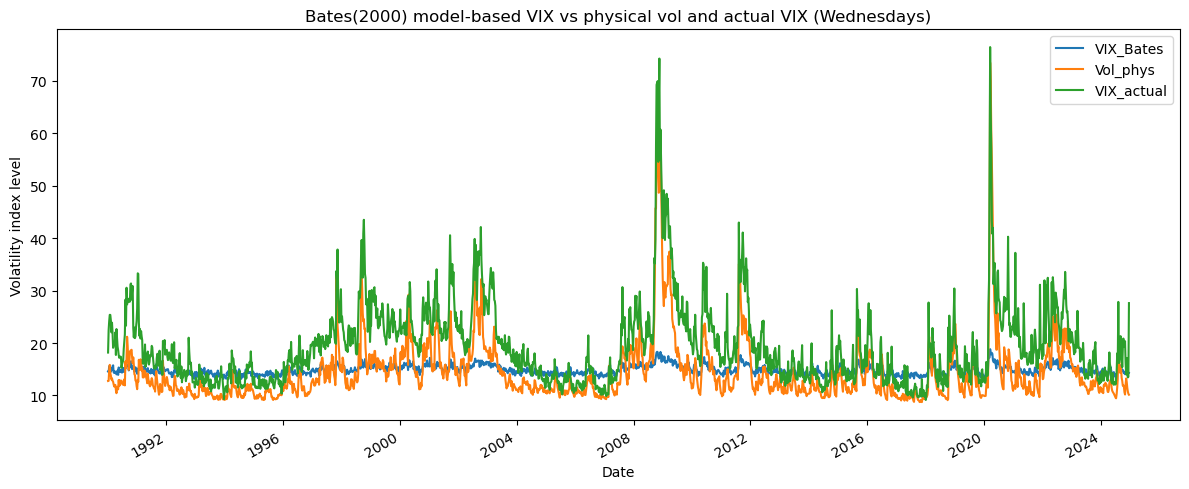

RMSE Bates vs actual VIX (full sample): 8.4671

Correlation matrix:
            VIX_Bates  Vol_phys  VIX_actual
VIX_Bates    1.000000  0.825548    0.799581
Vol_phys     0.825548  1.000000    0.881932
VIX_actual   0.799581  0.881932    1.000000

Summary stats:
         VIX_Bates     Vol_phys   VIX_actual
count  1805.000000  1805.000000  1805.000000
mean     14.870361    14.329117    19.443889
std       0.862739     6.100802     7.798583
min      13.041521     8.740752     9.150000
25%      14.245716    10.857657    13.790000
50%      14.731663    12.540184    17.770000
75%      15.400966    15.825167    22.690000
max      18.834588    73.498662    76.450000


In [53]:
# ---------- Full-sample Bates VIX using calibrated params ----------
vix_bates_full = compute_bates_vix_series(batesQ_params, wed_dates, n_paths=20000)

bates_df = pd.concat(
    [
        vix_bates_full.rename("VIX_Bates"),
        duan_vol_ann.rename("Vol_phys"),
        vix_close.rename("VIX_actual"),
    ],
    axis=1,
    join="inner",
).dropna()

# Plot
fig, ax = plt.subplots(figsize=(12, 5))
bates_df[["VIX_Bates", "Vol_phys", "VIX_actual"]].plot(ax=ax)
ax.set_title("Bates(2000) model-based VIX vs physical vol and actual VIX (Wednesdays)")
ax.set_ylabel("Volatility index level")
ax.set_xlabel("Date")
plt.tight_layout()
plt.show()

# RMSE and correlations
rmse_bates = np.sqrt(((bates_df["VIX_Bates"] - bates_df["VIX_actual"])**2).mean())
print(f"RMSE Bates vs actual VIX (full sample): {rmse_bates:.4f}\n")

print("Correlation matrix:")
print(bates_df.corr())
print("\nSummary stats:")
print(bates_df.describe())


Calibration result [theta_v, lambdaJ, muJ, sigmaJ]:
[ 0.01        0.19882393 -0.65427795  0.05      ]    RMSE on calib set: 5.805011453274163


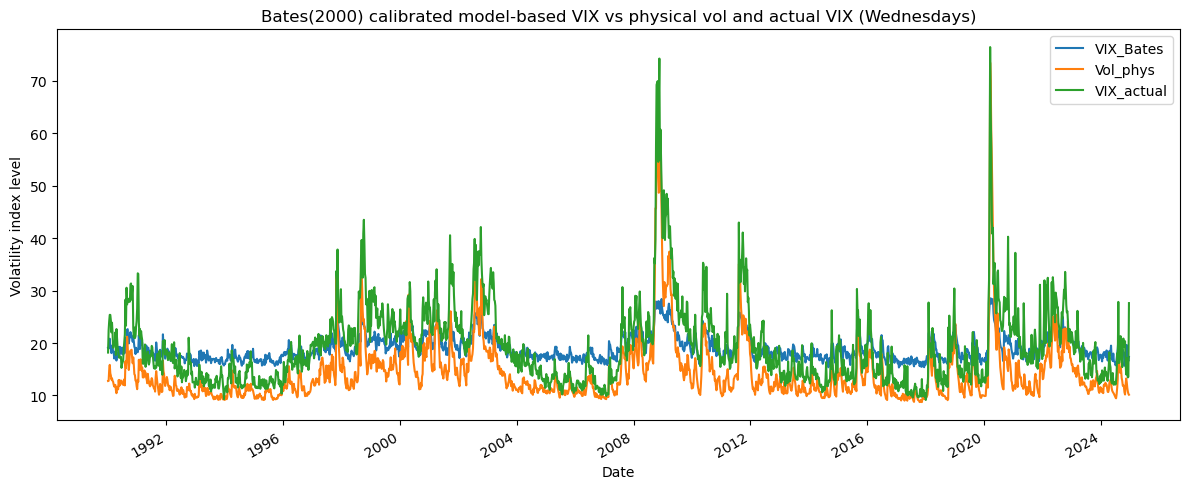


RMSE Bates vs actual VIX (full sample): 5.9458

Correlation matrix:
            VIX_Bates  Vol_phys  VIX_actual
VIX_Bates    1.000000  0.897377    0.850730
Vol_phys     0.897377  1.000000    0.881932
VIX_actual   0.850730  0.881932    1.000000 

Summary statistics:
         VIX_Bates     Vol_phys   VIX_actual
count  1805.000000  1805.000000  1805.000000
mean     19.001863    14.329117    19.443889
std       2.347929     6.100802     7.798583
min      15.244702     8.740752     9.150000
25%      17.281184    10.857657    13.790000
50%      18.398810    12.540184    17.770000
75%      20.249954    15.825167    22.690000
max      28.542650    73.498662    76.450000


In [55]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# ==========================
# 0. Prep: NGARCH-based physical vol
# ==========================
h_series = pd.Series(h, index=r.index, name="h")
duan_vol_ann = np.sqrt(252.0 * h_series) * 100.0   # 100× daily vol → annual %


# ==========================
# 1. Bates(2000) dynamics under Q
# ==========================

# Fixed “shape” parameters; we'll calibrate theta_v, lambdaJ, muJ, sigmaJ
batesQ_params = {
    "kappa_v":  2.0,    # speed of mean reversion (fixed)
    "theta_v":  0.04,   # long-run variance (to be calibrated)
    "sigma_v":  0.5,    # vol-of-vol (fixed)
    "rho":     -0.7,    # corr(dW1,dW2) (fixed)
    "lambdaJ":  0.5,    # jump intensity per YEAR (to be calibrated)
    "muJ":     -0.10,   # mean log jump (to be calibrated)
    "sigmaJ":   0.20    # std log jump (to be calibrated)
}


def simulate_bates_paths_Q(S0, v0, rf_ann, y_ann, params,
                           n_days=21, n_paths=10000, random_state=None):
    """
    Simulate Bates (Heston + jumps) under Q for n_days business days.
    v0 is daily variance; rf_ann, y_ann are ANNUAL rates (decimals).
    """
    rng = np.random.default_rng(random_state)

    kappa_v = params["kappa_v"]
    theta_v = params["theta_v"]
    sigma_v = params["sigma_v"]
    rho     = params["rho"]
    lambdaJ = params["lambdaJ"]   # per year
    muJ     = params["muJ"]
    sigmaJ  = params["sigmaJ"]

    kappaJ     = np.exp(muJ + 0.5 * sigmaJ**2) - 1.0
    dt         = 1.0 / 252.0
    lambdaJ_dt = lambdaJ * dt

    S = np.full(n_paths, S0, dtype=float)
    v = np.full(n_paths, v0, dtype=float)

    for _ in range(n_days):
        # correlated Brownian increments
        z1 = rng.standard_normal(n_paths)
        z2 = rng.standard_normal(n_paths)
        dW1 = np.sqrt(dt) * z1
        dW2 = np.sqrt(dt) * (rho * z1 + np.sqrt(1 - rho**2) * z2)

        # variance (Heston, full truncation)
        v = np.maximum(v, 0.0)
        v_prev = v.copy()
        v = v_prev + kappa_v * (theta_v - v_prev) * dt \
                 + sigma_v * np.sqrt(np.maximum(v_prev, 0.0)) * dW2
        v = np.maximum(v, 0.0)

        # jumps
        nJumps = rng.poisson(lambdaJ_dt, size=n_paths)
        J = np.exp(muJ + sigmaJ * rng.standard_normal(n_paths))
        jump_factor = np.where(nJumps > 0, J, 1.0)

        # risk-neutral log-return
        mu_q = rf_ann - y_ann - lambdaJ * kappaJ
        dlogS = (mu_q - 0.5 * v_prev) * dt + np.sqrt(np.maximum(v_prev, 0.0)) * dW1

        S *= np.exp(dlogS) * jump_factor

    return S, v


def compute_bates_vix_series(params, dates, n_paths=8000, rng_seed=1234):
    """
    Compute Bates model-based VIX on a set of dates (typically Wednesdays).
    Uses NGARCH h_t as current variance v0 at each date.
    """
    m_grid       = build_m_grid()
    horizon_days = 21
    vix_bates = pd.Series(index=dates, dtype=float)

    for i, d in enumerate(dates):
        S0   = spx.loc[d, 'spindx']
        v0   = h_series.loc[d]
        rf_d = rf_daily.loc[d]    # daily
        y_d  = y_daily.loc[d]

        rf_ann = rf_d * 252.0
        y_ann  = y_d  * 252.0

        # deterministic RNG across parameter sets: seed + index
        S_T, v_T = simulate_bates_paths_Q(
            S0, v0, rf_ann, y_ann, params,
            n_days=horizon_days,
            n_paths=n_paths,
            random_state=rng_seed + i
        )

        # 30-calendar-day forward & discount
        F, df, R_f, T = forward_and_discount(S0, rf_d, y_d, T_days=30)

        # standardized-m strikes using current variance v0
        sigma_bar = np.sqrt((252.0 / 12.0) * v0)
        strikes = F * np.exp(m_grid * sigma_bar)

        call_prices, put_prices = [], []
        for K in strikes:
            payoff_call = np.maximum(S_T - K, 0.0)
            payoff_put  = np.maximum(K - S_T, 0.0)
            call_prices.append(df * payoff_call.mean())
            put_prices.append(df * payoff_put.mean())
        call_prices = np.array(call_prices)
        put_prices  = np.array(put_prices)

        VIX_b, _ = vix_from_option_curve(strikes, call_prices, put_prices, F, R_f, T)
        vix_bates.loc[d] = VIX_b

    return vix_bates


# ==========================
# 2. Extended calibration: θ_v, λ_J, μ_J, σ_J
# ==========================

# Wednesdays within the VIX sample
vix_start = vix_close.index.min()
vix_end   = vix_close.index.max()
common_dates = r.index[(r.index >= vix_start) & (r.index <= vix_end)]
wed_dates = common_dates[common_dates.weekday == 2]

# Subsample for calibration to keep it fast
calib_dates = wed_dates[::3]   # every 3rd Wednesday


def bates_rmse_extended(x):
    """
    x = [theta_v, lambdaJ, muJ, sigmaJ]
    returns RMSE between Bates VIX and actual VIX on calib_dates.
    """
    theta_v, lambdaJ, muJ, sigmaJ = x

    params_local = batesQ_params.copy()
    params_local["theta_v"] = theta_v
    params_local["lambdaJ"] = lambdaJ
    params_local["muJ"]     = muJ
    params_local["sigmaJ"]  = sigmaJ

    vix_bates_calib = compute_bates_vix_series(params_local, calib_dates,
                                               n_paths=5000, rng_seed=999)

    df_calib = pd.concat(
        [
            vix_bates_calib.rename("VIX_Bates"),
            vix_close.loc[calib_dates].rename("VIX_actual")
        ],
        axis=1
    ).dropna()

    rmse = np.sqrt(((df_calib["VIX_Bates"] - df_calib["VIX_actual"])**2).mean())
    return rmse


# Initial guess and bounds for (theta_v, lambdaJ, muJ, sigmaJ)
x0 = np.array([
    batesQ_params["theta_v"],
    batesQ_params["lambdaJ"],
    batesQ_params["muJ"],
    batesQ_params["sigmaJ"],
])

bounds = [
    (0.01, 0.15),     # theta_v: variance between ~10% and ~39% annual vol^2
    (0.01, 1.5),      # lambdaJ: 0.01–1.5 jumps per year
    (-0.8, 0.2),      # muJ: mean log jump [-0.8, 0.2]
    (0.05, 0.8),      # sigmaJ: jump volatility
]

res = minimize(bates_rmse_extended, x0, bounds=bounds, method="L-BFGS-B")
print("Calibration result [theta_v, lambdaJ, muJ, sigmaJ]:")
print(res.x, "   RMSE on calib set:", res.fun)

# Update global Bates params with calibrated values
batesQ_params["theta_v"] = res.x[0]
batesQ_params["lambdaJ"] = res.x[1]
batesQ_params["muJ"]     = res.x[2]
batesQ_params["sigmaJ"]  = res.x[3]


# ==========================
# 3. Full-sample Bates VIX with calibrated params
# ==========================

vix_bates_full = compute_bates_vix_series(batesQ_params, wed_dates,
                                          n_paths=20000, rng_seed=2025)

bates_df = pd.concat(
    [
        vix_bates_full.rename("VIX_Bates"),
        duan_vol_ann.rename("Vol_phys"),
        vix_close.rename("VIX_actual"),
    ],
    axis=1,
    join="inner",
).dropna()

# Plot
fig, ax = plt.subplots(figsize=(12, 5))
bates_df[["VIX_Bates", "Vol_phys", "VIX_actual"]].plot(ax=ax)
ax.set_title("Bates(2000) calibrated model-based VIX vs physical vol and actual VIX (Wednesdays)")
ax.set_ylabel("Volatility index level")
ax.set_xlabel("Date")
plt.tight_layout()
plt.show()

# Diagnostics
rmse_bates = np.sqrt(((bates_df["VIX_Bates"] - bates_df["VIX_actual"])**2).mean())
print(f"\nRMSE Bates vs actual VIX (full sample): {rmse_bates:.4f}\n")

print("Correlation matrix:")
print(bates_df.corr(), "\n")

print("Summary statistics:")
print(bates_df.describe())


In [56]:
print("RMSE Bates:", rmse_bates)
print("RMSE FHS:  ", rmse_fhs)      # from your Q5 code
print("RMSE Gauss:", rmse_gauss)    # from your Q3 code


RMSE Bates: 5.945750631472968
RMSE FHS:   4.0118512847496755
RMSE Gauss: 7.059671452089805
